Optimisation de la distribution (logits) de noise1 


In [13]:
# Cellule 1 : imports & données
import sys
sys.path.insert(0, '.')

import functions
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D
import os

device = 'cpu'  # passer à 'cuda' si dispo
torch.manual_seed(42)

# Chemins de sauvegarde
SAVE_DIR = r"C:\Users\gauti\OneDrive\Documents\UE D recherche\UE_D_Recherche\code"
LOGITS_FILENAME = "optimized_logitsn1_c2.pt"
SAVE_PATH = os.path.join(SAVE_DIR, LOGITS_FILENAME)
os.makedirs(SAVE_DIR, exist_ok=True)

# Données cibles
try:
    data = np.load("Train_TurbModane_N65536_sampling4_Nreal256_v3.npz")
    S2_target = torch.from_numpy(data['S2'].mean(axis=0)).float().to(device)
    flatness_target = torch.from_numpy(data['Flat'].mean(axis=0)).float().to(device)
    scales = torch.from_numpy(data["scales"]).float().to(device)
    print("Données cibles chargées.")
except FileNotFoundError:
    print("Erreur : fichier .npz introuvable")

Données cibles chargées.


In [14]:
# Cellule 2 : modèle & logits
# Hyperparamètres
N = 2**16
M = 1
alpha_loss = 0.3
beta_loss = 1.0
gamma_loss = 0.3

# Paramètres optimisables
c1_opt = torch.tensor(0.36, requires_grad=True, device=device)
c2_opt = torch.tensor(0.02, requires_grad=True, device=device)
delta_sigma_opt = torch.tensor(1.0, requires_grad=False, device=device)
h_mu_opt = torch.tensor(0.0, device=device)
h_sigma_opt = torch.tensor(1.0, device=device)

# Histogramme (loi du bruit)
n_bins = 300
bin_centers = torch.linspace(-6.0, 6.0, n_bins, device=device)

def load_or_init_logits():
    if os.path.exists(SAVE_PATH):
        print(f"Fichier trouvé : {SAVE_PATH}\nChargement des logits...")
        loaded = torch.load(SAVE_PATH, map_location=device)
        return torch.tensor(loaded, requires_grad=True, device=device)
    print(f"Aucun fichier à {SAVE_PATH}\nInit gaussienne.")
    return torch.tensor(D.Normal(0, 1).log_prob(bin_centers), requires_grad=True, device=device)

logits_opt = load_or_init_logits()

temperature = 2.0
smoothness_weight = 0.5

# Bruits fixes
base_noise1 = torch.randn(M, int(N), device=device)
fixed_uniform = torch.rand(M, int(N), n_bins, device=device)
fixed_gumbel_noise = -torch.log(-torch.log(fixed_uniform + 1e-9) + 1e-9)

optimizer = torch.optim.Adam([{'params': [logits_opt], 'lr': 0.01}])
print("Modèle prêt.")

Aucun fichier à C:\Users\gauti\OneDrive\Documents\UE D recherche\UE_D_Recherche\code\optimized_logitsn1_c2.pt
Init gaussienne.
Modèle prêt.


C:\Users\gauti\AppData\Local\Temp\ipykernel_7920\1599672675.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(D.Normal(0, 1).log_prob(bin_centers), requires_grad=True, device=device)


In [15]:
# Cellule 3 : optimisation
num_epochs = 50
loss_history, c2_history = [], []

print("Démarrage de l'optimisation...")

try:
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # 1. Gumbel-Softmax -> noise2
        current_logits = logits_opt.view(1, 1, -1).expand(M, int(N), n_bins)
        y_soft = F.softmax((current_logits + fixed_gumbel_noise) / temperature, dim=-1)
        noise2_raw = torch.sum(y_soft * bin_centers, dim=-1)
        noise2 = (noise2_raw - noise2_raw.mean(dim=1, keepdim=True)) / (noise2_raw.std(dim=1, keepdim=True) + 1e-8)

        # 2. Synthèse MRW (noise1 = bruit gaussien, noise2 = intermittence apprise)
        noise1 = base_noise1 * h_sigma_opt + h_mu_opt
        MRW = delta_sigma_opt * functions.synthMRWregul_Torch(
            noise2, noise1, int(N), c1_opt, c2_opt, np.exp(8), epsilon=1.0, win=1
        )

        # 3. Loss physique
        MRW_reshaped = torch.reshape(MRW, (-1, 2**16))
        moments = functions.analyseIncrsTorchcuda(MRW_reshaped, scales, device='cpu')
        S2_sim = torch.exp(moments[:, 0, :]).mean(dim=0)
        flat_sim = moments[:, 2, :].mean(dim=0)

        mse_lin_s2 = F.mse_loss(S2_sim, S2_target)
        mse_log_s2 = F.mse_loss(torch.log(S2_sim + 1e-10), torch.log(S2_target + 1e-10))
        loss_S2 = alpha_loss * mse_lin_s2 + (1 - alpha_loss) * mse_log_s2

        mse_lin_flat = F.mse_loss(flat_sim, flatness_target)
        mse_log_flat = F.mse_loss(torch.log(flat_sim + 1e-10), torch.log(flatness_target + 1e-10))
        loss_Flat = beta_loss * mse_lin_flat + (1 - beta_loss) * mse_log_flat

        loss_phy = gamma_loss * loss_S2 + (1 - gamma_loss) * loss_Flat * 1000

        # Régularisation des logits (lissage)
        diff_logits = logits_opt[1:] - logits_opt[:-1]
        loss_smooth = torch.sum(torch.abs(diff_logits))

        loss = loss_phy + smoothness_weight * loss_smooth
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        c2_history.append(c2_opt.item())

        if (epoch + 1) % 5 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f} | "
                f"loss_phy: {loss_phy.item():.4f} | loss_smooth: {loss_smooth.item():.4f} | "
                f"c1: {c1_opt.item():.4f} | c2: {c2_opt.item():.4f} | delta_sigma: {delta_sigma_opt.item():.4f}"
            )

except KeyboardInterrupt:
    print("Interruption manuelle. Sauvegarde...")

print(f"Sauvegarde des logits dans : {SAVE_PATH}")
torch.save(logits_opt.detach(), SAVE_PATH)
print("Sauvegarde terminée.")

Démarrage de l'optimisation...
Epoch 5/50 | Loss: 49.4044 | loss_phy: 31.2644 | loss_smooth: 36.2802 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 5/50 | Loss: 49.4044 | loss_phy: 31.2644 | loss_smooth: 36.2802 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 10/50 | Loss: 48.1124 | loss_phy: 30.0019 | loss_smooth: 36.2210 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 10/50 | Loss: 48.1124 | loss_phy: 30.0019 | loss_smooth: 36.2210 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 15/50 | Loss: 47.0278 | loss_phy: 28.9889 | loss_smooth: 36.0777 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 15/50 | Loss: 47.0278 | loss_phy: 28.9889 | loss_smooth: 36.0777 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 20/50 | Loss: 46.0076 | loss_phy: 28.0535 | loss_smooth: 35.9083 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 20/50 | Loss: 46.0076 | loss_phy: 28.0535 | loss_smooth: 35.9083 | c1: 0.3600 | c2: 0.0200 | delta_sigma: 1.0000
Epoch 25/50 | Loss:

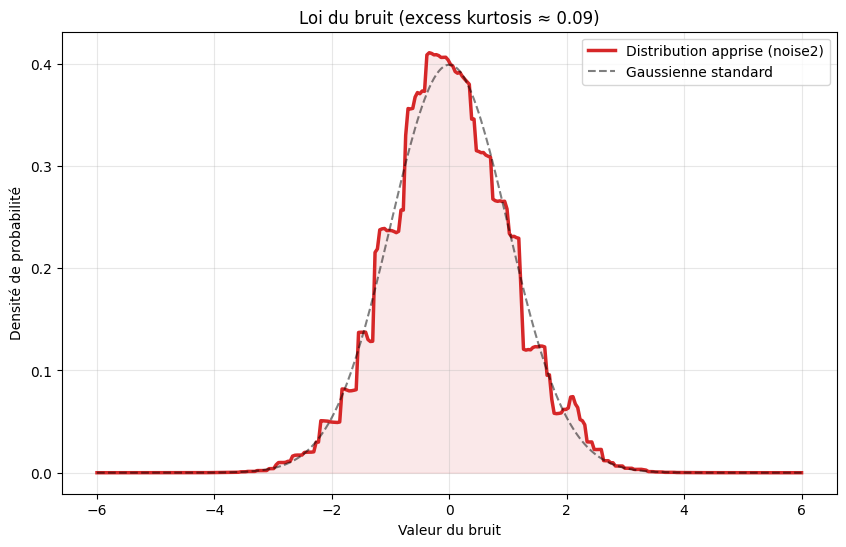

Génération d'un échantillon de validation...


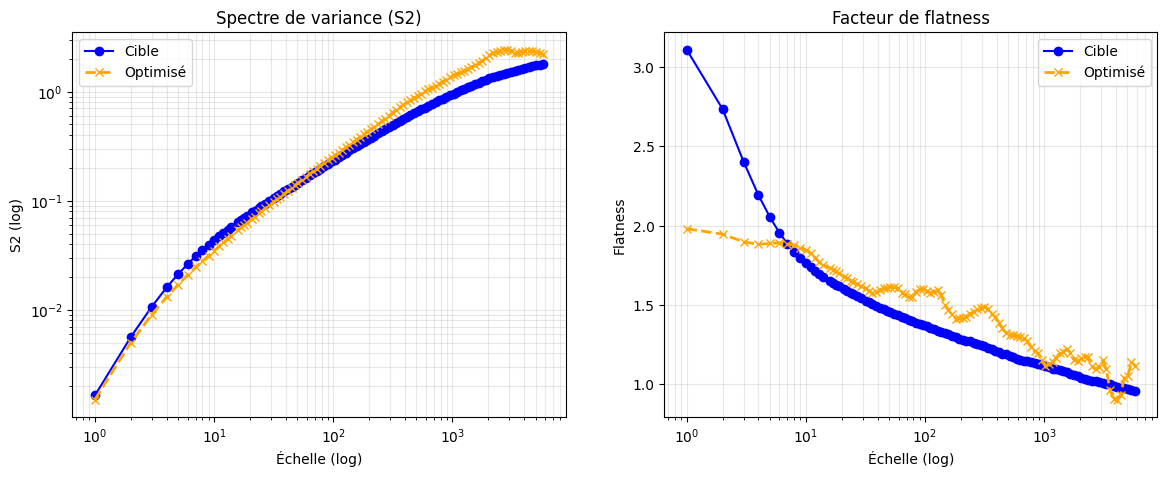

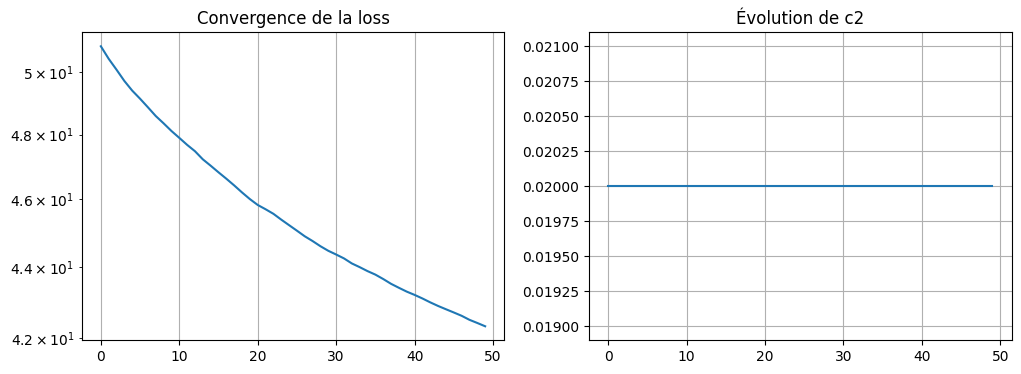

In [16]:
# Cellule 4 : analyse & visualisation
plt.style.use('default')

# 1) Loi apprise vs gaussienne
with torch.no_grad():
    x_axis = bin_centers.cpu().numpy()
    dx = x_axis[1] - x_axis[0]
    learned_probs = F.softmax(logits_opt, dim=0).cpu().numpy()
    learned_density = learned_probs / dx
    ref_density = torch.exp(D.Normal(0, 1).log_prob(bin_centers)).cpu().numpy()

    mean_dist = np.sum(x_axis * learned_probs)
    var_dist = np.sum(((x_axis - mean_dist)**2) * learned_probs)
    kurt_dist = np.sum(((x_axis - mean_dist)**4) * learned_probs) / (var_dist**2)
    excess_kurtosis = kurt_dist - 3

plt.figure(figsize=(10, 6))
plt.plot(x_axis, learned_density, label='Distribution apprise (noise2)', color='#d62728', linewidth=2.5)
plt.plot(x_axis, ref_density, '--', label='Gaussienne standard', color='black', alpha=0.5)
plt.fill_between(x_axis, learned_density, alpha=0.1, color='#d62728')
plt.title(f"Loi du bruit (excess kurtosis ≈ {excess_kurtosis:.2f})")
plt.xlabel("Valeur du bruit"); plt.ylabel("Densité de probabilité")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# 2) Vérification physique
print("Génération d'un échantillon de validation...")
with torch.no_grad():
    current_logits = logits_opt.view(1, 1, -1).expand(M, int(N), n_bins)
    random_uniform = torch.rand_like(fixed_uniform)
    random_gumbel = -torch.log(-torch.log(random_uniform + 1e-9) + 1e-9)
    y_soft = F.softmax((current_logits + random_gumbel) / temperature, dim=-1)
    noise2_raw = torch.sum(y_soft * bin_centers, dim=-1)
    noise2_final = (noise2_raw - noise2_raw.mean(dim=1, keepdim=True)) / (noise2_raw.std(dim=1, keepdim=True) + 1e-8)

    noise1 = base_noise1 * h_sigma_opt + h_mu_opt
    MRW_final = delta_sigma_opt * functions.synthMRWregul_Torch(
        noise2_final, noise1, int(N), c1_opt, c2_opt, np.exp(8), epsilon=1.0, win=1
    )

    MRW_reshaped = torch.reshape(MRW_final, (-1, 2**16))
    moments_final = functions.analyseIncrsTorchcuda(MRW_reshaped, scales, device='cpu')
    S2_optim = torch.exp(moments_final[:, 0, :]).mean(dim=0).cpu().numpy()
    flat_optim = moments_final[:, 2, :].mean(dim=0).cpu().numpy()

scales_np = scales.cpu().numpy()
s2_target_np = S2_target.cpu().numpy()
flat_target_np = flatness_target.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.loglog(scales_np, s2_target_np, 'o-', label='Cible', color='blue')
ax1.loglog(scales_np, S2_optim, 'x--', label='Optimisé', color='orange', linewidth=2)
ax1.set_xlabel("Échelle (log)"); ax1.set_ylabel("S2 (log)"); ax1.set_title("Spectre de variance (S2)")
ax1.legend(); ax1.grid(True, which="both", alpha=0.3)

ax2.semilogx(scales_np, flat_target_np, 'o-', label='Cible', color='blue')
ax2.semilogx(scales_np, flat_optim, 'x--', label='Optimisé', color='orange', linewidth=2)
ax2.set_xlabel("Échelle (log)"); ax2.set_ylabel("Flatness"); ax2.set_title("Facteur de flatness")
ax2.legend(); ax2.grid(True, which="both", alpha=0.3)
plt.show()

# 3) Historique
y = len(loss_history)
if y > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(loss_history); ax1.set_title("Convergence de la loss"); ax1.set_yscale("log"); ax1.grid(True)
    ax2.plot(c2_history); ax2.set_title("Évolution de c2"); ax2.grid(True)
    plt.show()
else:
    print("Pas d'historique (modèle chargé).")